https://www.tandfonline.com/doi/abs/10.13182/FST95-A30485

## Model for Tritium Extraction from Pb-17Li (or other liquid) by Bubble Columns

In [51]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
from scipy import constants as const
from scipy.optimize import fsolve
from scipy.optimize import root_scalar

def solve_tritium_extraction(dimensionless_params, y_T2_in, elements):
        """
        Solves the BVP for tritium extraction in a bubble column.

        Args:
            params (dict): A dictionary containing the dimensionless parameters:
                        Bo_l, phi_l, Bo_g, phi_g, psi, nu.
            y_T2_in (float): Inlet tritium molar fraction in the gas phase, y_T2(0-).

        Returns:
            sol: The solution object from scipy.integrate.solve_bvp.
        """

        Bo_l = dimensionless_params["Bo_l"]
        phi_l = dimensionless_params["phi_l"]
        Bo_g = dimensionless_params["Bo_g"]
        phi_g = dimensionless_params["phi_g"]
        psi = dimensionless_params["psi"]
        nu = dimensionless_params["nu"]

        def ode_system(xi, S):
            """
            Defines the system of 4 first-order ODEs.
            S[0] = x_T  (dimensionless liquid concentration)
            S[1] = dx_T/d(xi)
            S[2] = y_T2 (dimensionless gas concentration)
            S[3] = dy_T2/d(xi)

            x_T = c_T / c_T(L+)
            xi = z / L (dimensionless position)
            """
            x_T, dx_T_dxi, y_T2, dy_T2_dxi = S

            # Dimensionless driving force theta. Eq. 8.8
            theta = x_T - np.sqrt( ((1 - (psi * xi)) / nu) * y_T2) # MATCHES PAPER

            # Equation for d(S[0])/d(xi) = d(x_T)/d(xi)
            dS0_dxi = dx_T_dxi 

            # Equation for d(S[1])/d(xi) = d^2(x_T)/d(xi)^2
            dS1_dxi = Bo_l * (phi_l * theta - dx_T_dxi)

            # Equation for d(S[2])/d(xi) = d(y_T2)/d(xi)
            dS2_dxi = dy_T2_dxi

            # Equation for d(S[3])/d(xi) = d^2(y_T2)/d(xi)^2 from eq (11)
            # Avoid division by zero if (1 - psi * xi) is close to zero at xi=1
            denominator = 1 - psi * xi

            term1 = (1 + 2 * psi / Bo_g) * dy_T2_dxi  # Part of Eq. 9.3.3 (fourth line)
            term2 = phi_g * theta  # Part of Eq. 9.3.3 (fourth line)
            dS3_dxi = (Bo_g / denominator) * (term1 - term2)  # Eq. 9.3.3 (fourth line)

            return np.vstack((dS0_dxi, dS1_dxi, dS2_dxi, dS3_dxi))

        def boundary_conditions(Sa, Sb):
            """
            Defines the boundary conditions for the BVP, depending on the case defined by "BCs".
            Sa: solution at xi = 0 (liquid outlet)
            Sb: solution at xi = 1 (liquid inlet)
            """
            if BCs == "C-C":
                # Closed-Closed case boundary conditions
                # At xi = 0: dx_T/d(xi) = 0
                res1 = Sa[1]  # Eq. 10.1

                # At xi = 1: x_T(1) = 1 - (1/Bo_l) * dx_T/d(xi)|_1
                res2 = Sb[0] - 1 + (1 / Bo_l) * Sb[1]  # Eq. 10.2

                # At xi = 0: y_T2(0) = y_T2(0-) + (1/Bo_g) * dy_T2/d(xi)|_0
                res3 = Sa[2] - y_T2_in - (1 / Bo_g) * Sa[3]  # Eq. 10.3

                # At xi = 1: dy_T2/d(xi) = 0
                res4 = Sb[3]  # Eq. 10.4

                return np.array([res1, res2, res3, res4])
            elif BCs == "O-C":
                # # Open-Closed case boundary conditions
                # At xi = 0: dx_T/d(xi) = 0
                res1 = Sa[1]  # Eq. 10.1

                # At xi = 1: x_T(1) = 1 - (1/Bo_l) * dx_T/d(xi)|_1
                res2 = Sb[0] - 1 # + (1 / Bo_l) * Sb[1]  # Eq. 10.2

                # At xi = 0: y_T2(0) = y_T2(0-) + (1/Bo_g) * dy_T2/d(xi)|_0
                res3 = Sa[2] - y_T2_in # - (1 / Bo_g) * Sa[3]  # Eq. 10.3

                # At xi = 1: dy_T2/d(xi) = 0
                res4 = Sb[3]  # Eq. 10.4

                return np.array([res1, res2, res3, res4])

        # Set up the mesh and an initial guess for the solver.
        xi = np.linspace(0, 1, elements + 1)

        y_guess = np.zeros((4, xi.size))

        # Run the BVP solver
        sol = solve_bvp(ode_system, boundary_conditions, xi, y_guess, tol=1e-5, max_nodes=10000)

        return sol


if __name__ == '__main__':
    
    # --- User Input Parameters ---
    # Bubble Column parameters
    c_T_inlet = 1.96e-2  # mol/m^3 (c_T(L+)), Inlet tritium concentration in liquid just before inlet
    y_T2_in = 1e-20  # Inlet tritium molar fraction in gas (0 = pure purge gas)
    P_0 = 5e5  # Pa, Gas total pressure at outlet
    BCs = "O-C" # Boundary conditions type: "O-C" (Open-Closed) or "C-C" (Closed-Closed)

    L = 3  # m, Height of the bubble column
    D = 0.5  # m, Column diameter

    Flow_l = 560 # kg/s, Liquid mass flow rate
    Flow_g = 0.19 # mol/s, Gas molar flow rate
    
    T = 623  # K, Temperature

    # Solver parameters
    elements = 50  # Number of mesh elements for solver

    # --- Constants ---
    g = 9.81  # m/s^2, Gravitational acceleration
    R = const.R  # J/(mol·K), Universal gas constant
    N_A = const.N_A  # 1/mol, Avogadro's number
    M_LiPb = 2.875E-25 # Kg/molecule, Lipb molecular mass

    # --- Calculated parameters ---

    # Calculate empirical correlations
    ρ_l = 10.45e3 * (1 - 1.61e-4 * T)  # kg/m^3, Liquid (LiPb) density
    σ_l = 0.52 - 0.11e-3 * T  # N/m, Surface tension, liquid (LiPb) - gas (He) interface
    μ_l = 1.87e-4 * np.exp(11640 / (R*T))  # Pa.s, Dynamic viscosity of liquid LiPb
    ν_l = μ_l / ρ_l # m^2/s, Kinematic viscosity of liquid LiPb
    D_T = 2.5E-7 * np.exp(-27000/(R*T))  # m^2/s, Tritium diffusion coefficient in liquid LiPb

    K_s = 2.32E-8 * np.exp(-1350 / (R*T))  # atfrac*Pa^0.5, Sievert's constant for tritium in liquid LiPb
    K_s = K_s * (ρ_l / (M_LiPb * N_A))  # mol/(m^3·Pa^0.5)


    # Calculate the volumetric flow rates
    Q_l = Flow_l / ρ_l  # m^3/s, Volumetric flow rate of liquid phase
    Q_g = (Flow_g * R * T) / P_0  # m^3/s, Volumetric flow rate of gas phase at inlet

    # Calculate the superficial flow velocities
    A = np.pi * (D / 2) ** 2  # m^2, Cross-sectional area of the column
    u_g0 = Q_g / A  # m/s, superficial gas inlet velocity
    u_l = Q_l / A  # m/s, superficial liquid inlet velocity

    # Calculate Bond, Galilei, Schmidt and Froude numbers
    Bn = (g * D**2 * ρ_l) / σ_l  # Bond number
    Ga = (g * D**3) / ν_l**2  # Galilei number
    Sc = ν_l / D_T # Schmidt number
    Fr = u_g0 / (g * D)**0.5  # Froude number

    # Calculate dispersion coefficients
    E_l = (D * u_g0) / ((13 * Fr) / (1 + 6.5*(Fr**0.8)) ) # m^2/s, Effective axial dispersion coefficient, liquid phase
    E_g = (0.2 * D**2) * u_g0 # m^2/s, Effective axial dispersion coefficient, gas phase


    # Calculate gas hold-up (phase fraction) & mass transfer coefficient
    C = 0.2 * (Bn**(1/8)) * (Ga**(1/12)) * Fr # C = ε_g / (1 - ε_g)^4

    print(C)

    def solveEqn(ε_g, C):
        # Define the equation to solve
        eqn = (ε_g / (1 - ε_g)**4) - C
        return eqn
    ε_g_initial_guess = 0.1
    try:
        # bracket=[0.0001, 0.9999] tells it to *only* look in this range
        sol = root_scalar(solveEqn, args=(C,), bracket=[0.00001, 0.99999])
        
        # print(f"--- Using root_scalar (robust method) ---")
        # print(f"C value was: {C}")
        # if sol.converged:
        #     print(f"Solved gas hold-up (εg): {sol.root:.6f}")
        #     # Verify it
        #     verification = sol.root / (1 - sol.root)**4
        #     print(f"Verification (should equal C): {verification:.6f}")
        # else:
        #     print("Solver did not converge.")

    except ValueError as e:
        print(f"Solver failed. This can happen if C is so large that no solution exists between 0 and 1.")
        print(f"Error: {e}")

    ε_g = sol.root # Gas phase fraction
    
    ε_l = 1 - ε_g  # Liquid phase fraction

    # Calculate outlet pressure hydrostatically & check non-negative
    P_outlet = P_0 - ( ρ_l * (1 - ε_g) * g * L)

    if P_0 <= 0:
        raise ValueError(
            f"Calculated gas outlet pressure P_outlet must be positive, but got {P_outlet:.2e} Pa. Check P_0, rho_l, g, and L are realistic."
        )

    # Calculate interfacial area
    d_b = (26 * (Bn**-0.5) * (Ga**-0.12) * (Fr**-0.12)) * D  # m, Mean bubble diameter
    a = 6 * ε_g / d_b  # m^-1, Specific interfacial area, assuming spherical bubbles

    # Calculate volumetric mass transfer coefficient, liquid-gas
    h_l_a = D_T * (0.6 * Sc**0.5 * Bn**0.62 * Ga**0.31 * ε_g**1.1) / (D**2)  # Volumetric mass transfer coefficient, liquid-gas

    h_l = h_l_a / a # Mass transfer coefficient

    # Print summary of input & calculated parameters
    print("=== Bubble Column Tritium Extraction Model ===")
    print(f"---------- User Input Parameters ----------")
    print(f"Column Height, L: {L:.2f} m")
    print(f"Column Diameter, D: {D:.2f} m")
    print(f"Liquid Inlet Tritium Concentration, c_T_inlet: {c_T_inlet:.4e} mol/m^3")
    print(f"Gas Inlet Tritium Molar Fraction, y_T2_in: {y_T2_in:.4e}")
    print(f"Temperature, T: {T:.2f} K")
    print(f"Liquid Mass Flow Rate, Flow_l: {Flow_l:.2f} kg/s")
    print(f"Gas Molar Flow Rate, Flow_g: {Flow_g:.2f} mol/s")
    print(f"Gas Inlet Total Pressure, P_0: {P_0:.2e} Pa")

    print("\nCalculated Parameters:")
    print(f"---------- System Parameters ----------")
    print(f"Gas Outlet Total Pressure, P_outlet: {P_outlet:.2e} Pa")
    print(f"Volumetric Flow Rate of Liquid, Q_l: {Q_l:.4e} m^3/s")
    print(f"Volumetric Flow Rate of Gas, Q_g: {Q_g:.4e} m^3/s")
    print(f"Superficial Gas Inlet Velocity, u_g0: {u_g0:.4e} m/s")
    print(f"Superficial Liquid Velocity, u_l: {u_l:.4e} m/s")

    print(f"\n---------- Material Properties at {T:.2f} °K ----------")
    print(f"Liquid Density, ρ_l: {ρ_l:.2f} kg/m^3")
    print(f"Surface Tension of Liquid-Gas interface, σ_1: {σ_l:.2f} N/m")
    print(f"Kinetic Viscosity of Liquid, ν_l: {ν_l:.4e} Pa.s")
    print(f"Dynamic Viscosity of Liquid, μ_l: {μ_l:.4e} Pa.s")
    print(f"Tritium Diffusion Coefficient in Liquid, D_T: {D_T:.4e} m^2/s")
    print(f"Sievert's Constant for Tritium in Liquid, K_s: {K_s:.4e} mol/(m^3·Pa^0.5)")

    print(f"\n---------- Calculated GLC Parameters ----------")
    print(f"Effective Axial Dispersion Coefficient, Liquid Phase, E_l: {E_l:.4e} m^2/s")
    print(f"Effective Axial Dispersion Coefficient, Gas Phase, E_g: {E_g:.4e} m^2/s")
    print(f"Gas Phase Fraction, ε_g: {ε_g:.4e}")
    print(f"Liquid Phase Fraction, ε_l: {ε_l:.4e}")
    print(f"Volumetric Mass Transfer Coefficient, a * h_l: {h_l_a:.4e} s^-1")
    print(f"Mean Bubble Diameter, d_b: {d_b:.4e} m")
    print(f"Specific Interfacial Area, a: {a:.4e} m^-1")
    print(f"Mass Transfer Coefficient, h_l: {h_l:.4e} m/s")

    # Calculate dimensionless values

    psi = (ρ_l * g * (1 - ε_g) * L) / P_0  # Hydrostatic pressure ratio (Eq. 8.3) # MATCHES PAPER
    nu = ((c_T_inlet / K_s) ** 2) / P_0  # Tritium partial pressure ratio (Eq. 8.5) # MATCHES PAPER
    Bo_l = u_l * L / (ε_l * E_l)  # Bodenstein number, liquid phase (Eq. 8.9) # MATCHES PAPER
    phi_l = a * h_l * L / u_l  # Transfer units parameter, liquid phase (Eq. 8.11) # MATCHES PAPER
    Bo_g = u_g0 * L / (ε_g * E_g)  # Bodenstein number, gas phase (Eq. 8.10) # MATCHES PAPER ASSUMING u_g0
    phi_g = 0.5 * (R * T * c_T_inlet / P_0) * (a * h_l * L / u_g0)  # Transfer units parameter, gas phase (Eq. 8.12) # MATCHES PAPER


    dimensionless_params = {
        "Bo_l": Bo_l,
        "phi_l": phi_l,
        "Bo_g": Bo_g,
        "phi_g": phi_g,
        "psi": psi,
        "nu": nu,
    }

    # Solve the model assuming pure purge gas at the inlet
    solution = solve_tritium_extraction(dimensionless_params, y_T2_in, elements)

    # --- Results & Plotting ---
    if solution.success:
        print("BVP solver converged successfully.")
        
        x_T_outlet_dimless = solution.y[0, 0]
        efficiency = 1 - x_T_outlet_dimless
        y_T2_outlet_gas = solution.y[2, -1]  # y_T2 at xi=1

        # --- Dimensional Results ---
        # Liquid concentration at outlet (xi=0)
        c_T_outlet = x_T_outlet_dimless * c_T_inlet

        # Gas partial pressure at outlet (xi=1)
        P_outlet = P_0 * (
            1 - dimensionless_params["psi"]
        )  # Derived from Eq. 8.4 at xi=1
        P_T2_out = y_T2_outlet_gas * P_outlet

        # Mass transfer consistency check
        N_A = const.N_A  # Avogadro's number, 1/mol
        # Tritium molar flow rate into the column via liquid
        n_T_in_liquid = c_T_inlet * Q_l * N_A  # Triton/s

        # Tritium molar flow rate out of the column via liquid
        n_T_out_liquid = c_T_outlet * Q_l * N_A  # Tritons/s

        # Tritium molar flow rate into the column via gas
        P_T2_in = y_T2_in * P_0 # [Pa]
        n_T2_in_gas = (P_T2_in * Q_g / (R * T)) * N_A  # T2/s
        n_T_in_gas = n_T2_in_gas * 2  # Triton/s

        # Calculate outlet gas volumetric flow rate (gas expands as pressure drops)
        Q_g_out = (P_0 * Q_g) / P_outlet
        # Tritium molar flow rate out of the column via gas
        n_T2_out_gas = (P_T2_out * Q_g_out / (R * T)) * N_A  # T2/s
        n_T_out_gas = n_T2_out_gas * 2  # Triton/s

        T_in = n_T_in_liquid + n_T_in_gas
        T_out = n_T_out_liquid + n_T_out_gas

        print("\n--- Results ---")
        print(f"Extraction Efficiency: {efficiency*100:.2f}%")
        print(f"Outlet Gas Molar Fraction of T2, y_T2_outlet: {y_T2_outlet_gas:.4e}")
        

        # Analytic estimate of extraction efficiency for comparison
        Ma = (1 + 4 * phi_l / Bo_l)**0.5
        lambda_plus = Bo_l * (Ma-1)/2
        lambda_minus = Bo_l * (Ma+1)/2
        H_l = (Ma+1)**2 * np.exp(lambda_plus * 1) - (Ma-1)**2 * np.exp(-lambda_minus * 1)

        efficiency_analytical = 1 - (4 * Ma)/H_l
        print(f"Analytical Extraction Efficiency Estimate: {efficiency_analytical*100:.2f}%")


    else:
        print("BVP solver failed to converge.")




0.04716287549109939
=== Bubble Column Tritium Extraction Model ===
---------- User Input Parameters ----------
Column Height, L: 3.00 m
Column Diameter, D: 0.50 m
Liquid Inlet Tritium Concentration, c_T_inlet: 1.9600e-02 mol/m^3
Gas Inlet Tritium Molar Fraction, y_T2_in: 1.0000e-20
Temperature, T: 623.00 K
Liquid Mass Flow Rate, Flow_l: 560.00 kg/s
Gas Molar Flow Rate, Flow_g: 0.19 mol/s
Gas Inlet Total Pressure, P_0: 5.00e+05 Pa

Calculated Parameters:
---------- System Parameters ----------
Gas Outlet Total Pressure, P_outlet: 2.34e+05 Pa
Volumetric Flow Rate of Liquid, Q_l: 5.9563e-02 m^3/s
Volumetric Flow Rate of Gas, Q_g: 1.9684e-03 m^3/s
Superficial Gas Inlet Velocity, u_g0: 1.0025e-02 m/s
Superficial Liquid Velocity, u_l: 3.0335e-01 m/s

---------- Material Properties at 623.00 °K ----------
Liquid Density, ρ_l: 9401.83 kg/m^3
Surface Tension of Liquid-Gas interface, σ_1: 0.45 N/m
Kinetic Viscosity of Liquid, ν_l: 1.8817e-07 Pa.s
Dynamic Viscosity of Liquid, μ_l: 1.7691e-03 Pa.s

## Import Mohan Paper Results

In [52]:
import pandas as pd

if BCs == "C-C":
    Mohan_xT = pd.read_csv('Mohan_results\Mohan_CC_xT.csv')
    Mohan_yT2 = pd.read_csv('Mohan_results\Mohan_CC_yT2.csv')
elif BCs == "O-C":
    Mohan_xT = pd.read_csv('Mohan_results\Mohan_OC_xT.csv')
    Mohan_yT2 = pd.read_csv('Mohan_results\Mohan_OC_yT2.csv')

<>:4: SyntaxWarning: invalid escape sequence '\M'
<>:5: SyntaxWarning: invalid escape sequence '\M'
<>:7: SyntaxWarning: invalid escape sequence '\M'
<>:8: SyntaxWarning: invalid escape sequence '\M'
<>:4: SyntaxWarning: invalid escape sequence '\M'
<>:5: SyntaxWarning: invalid escape sequence '\M'
<>:7: SyntaxWarning: invalid escape sequence '\M'
<>:8: SyntaxWarning: invalid escape sequence '\M'
C:\Users\vk9746\AppData\Local\Temp\ipykernel_32864\2544537925.py:4: SyntaxWarning: invalid escape sequence '\M'
  Mohan_xT = pd.read_csv('Mohan_results\Mohan_CC_xT.csv')
C:\Users\vk9746\AppData\Local\Temp\ipykernel_32864\2544537925.py:5: SyntaxWarning: invalid escape sequence '\M'
  Mohan_yT2 = pd.read_csv('Mohan_results\Mohan_CC_yT2.csv')
C:\Users\vk9746\AppData\Local\Temp\ipykernel_32864\2544537925.py:7: SyntaxWarning: invalid escape sequence '\M'
  Mohan_xT = pd.read_csv('Mohan_results\Mohan_OC_xT.csv')
C:\Users\vk9746\AppData\Local\Temp\ipykernel_32864\2544537925.py:8: SyntaxWarning: inval

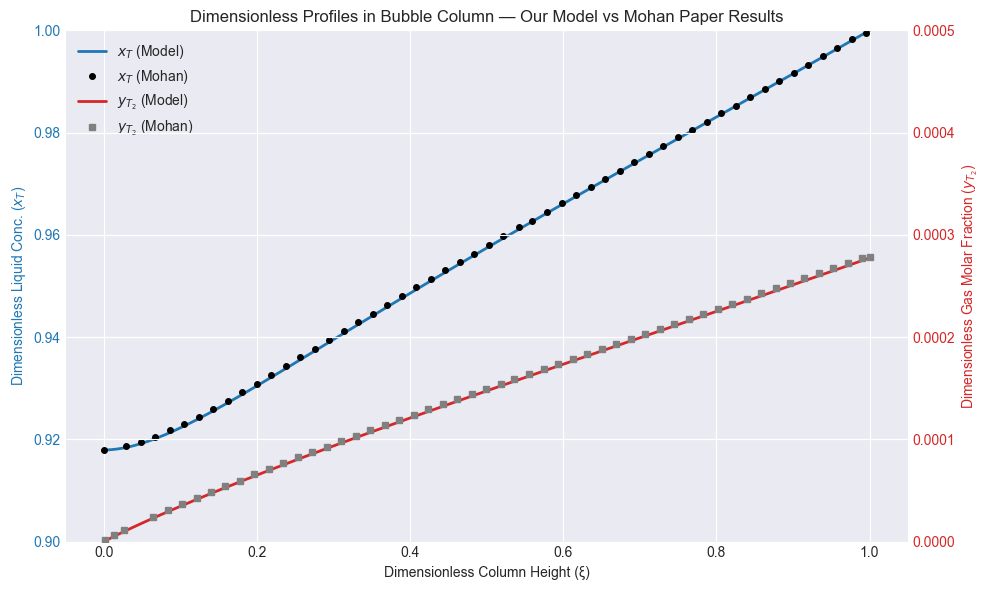

In [53]:

# --- Plot 1: Dimensionless Profiles ---
plt.style.use('seaborn-v0_8-darkgrid')
fig1, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Dimensionless Column Height (ξ)')
ax1.set_ylabel('Dimensionless Liquid Conc. ($x_T$)', color=color)
ax1.plot(solution.x, solution.y[0], label='$x_T$ (Model)', color=color, lw=2)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(bottom=0.9, top=1)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Dimensionless Gas Molar Fraction ($y_{T_2}$)', color=color)
ax2.plot(solution.x, solution.y[2], label='$y_{T_2}$ (Model)', color=color, lw=2)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(bottom=0, top=5e-4)

# plot Mohan xT on primary axis
ax1.plot(Mohan_xT.iloc[:,0], Mohan_xT.iloc[:,1], label='$x_T$ (Mohan)', color='black', marker='o', ls='None', ms=4)
# plot Mohan yT2 on secondary axis
ax2.plot(Mohan_yT2.iloc[:,0], Mohan_yT2.iloc[:,1], label='$y_{T_2}$ (Mohan)', color='gray', marker='s', ls='None', ms=4)

# --- Combined legend from both axes ---
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='best', ncol=1, framealpha=0.9)

plt.title('Dimensionless Profiles in Bubble Column — Our Model vs Mohan Paper Results')
fig1.tight_layout()